# Meta Data Maker

In [1]:
import xarray as xr
import numpy as np
import warnings
import cftime
from importlib import reload
import os, sys
from glob import glob
import constants
sys.path.append(constants.MODULE_DIR)
import json
# Custom plots for signal to noise functions.
import open_ds
import xarray_class_accessors as xca
warnings.filterwarnings('ignore')
import open_ds
import signal_to_noise as sn
import xarray_extender as xce
import utils
from pprint import pprint


In [11]:
from modules import ExperimentTypes

# Loading Data

In [22]:
ROOT_DIR = os.path.join(constants.LONGRUNMIP_DIR, 'tas', 'regrid_retimestamped')
ROOT_DIR

'/g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped'

In [24]:
fnames_abrupt4x = list(map(os.path.basename, glob(os.path.join(ROOT_DIR, '*abrupt4x*'))))
abrupt4x_ds = open_ds.read_and_merge_netcdfs(fnames_abrupt4x, ROOT_DIR)
abrupt4x_ds

<xarray.Dataset>
Dimensions:      (time: 5900, lon: 144, lat: 72)
Coordinates:
  * time         (time) object 0001-12-31 00:00:00 ... 5900-12-31 00:00:00
  * lon          (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat          (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
Data variables: (12/15)
    echam5mpiom  (time, lat, lon) float32 229.7 229.4 229.4 ... nan nan nan
    ecearth      (time, lat, lon) float32 228.2 228.1 228.1 ... nan nan nan
    hadgem2      (time, lat, lon) float32 231.6 231.5 231.5 ... nan nan nan
    gisse2r      (time, lat, lon) float32 226.4 226.3 226.3 ... nan nan nan
    mpiesm12     (time, lat, lon) float32 224.6 224.5 224.5 ... nan nan nan
    cnrmcm61     (time, lat, lon) float32 225.8 225.8 225.8 ... nan nan nan
    ...           ...
    cesm104      (time, lat, lon) float32 ...
    famous       (time, lat, lon) float32 226.6 226.6 226.5 ... nan nan nan
    hadcm3l      (time, lat, lon) float64 229.2 229.1 229.2 ... nan nan nan
    ipslcm5a     (time, lat, lon) float32 230.3 230.1 230.0 ... nan nan nan
    gfdlcm3      (time, lat, lon) float32 224.6 224.5 224.4 ... nan nan nan
    gfdlesm2m    (time, lat, lon) float32 230.8 230.7 230.5 ... nan nan nan
Attributes:
    length:   1001

In [25]:
fnames_control = list(map(os.path.basename, glob(os.path.join(ROOT_DIR, '*control*'))))
control_ds = open_ds.read_and_merge_netcdfs(fnames_control, ROOT_DIR)
control_ds

<xarray.Dataset>
Dimensions:      (time: 5200, lon: 144, lat: 72)
Coordinates:
  * time         (time) object 0001-12-31 00:00:00 ... 5200-12-31 00:00:00
  * lon          (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat          (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
Data variables: (12/15)
    hadgem2      (time, lat, lon) float32 226.3 226.3 226.3 ... nan nan nan
    hadcm3l      (time, lat, lon) float64 227.3 227.3 227.5 ... nan nan nan
    gfdlcm3      (time, lat, lon) float32 ...
    ccsm3        (time, lat, lon) float32 234.3 234.0 234.0 ... nan nan nan
    gisse2r      (time, lat, lon) float32 234.2 233.8 233.8 ... nan nan nan
    mpiesm11     (time, lat, lon) float32 224.7 224.7 224.6 ... nan nan nan
    ...           ...
    mpiesm12     (time, lat, lon) float32 224.4 224.4 224.4 ... nan nan nan
    famous       (time, lat, lon) float32 224.5 224.4 224.4 ... nan nan nan
    cesm104      (time, lat, lon) float32 227.5 227.4 227.3 ... nan nan nan
    ecearth      (time, lat, lon) float32 227.0 226.9 226.9 ... nan nan nan
    miroc32      (time, lat, lon) float32 227.2 227.0 226.9 ... nan nan nan
    cnrmcm61     (time, lat, lon) float32 224.1 224.1 224.1 ... nan nan nan
Attributes:
    standard_name:  air_temperature
    units:          K
    cell_methods:   area: mean time: mean
    length:         239

In [26]:
# Need the intersection: just want the models that have abrupt 4x and a control.
models = np.intersect1d(list(control_ds.data_vars),  list(abrupt4x_ds.data_vars))
control_ds = control_ds[models]
abrupt4x_ds = abrupt4x_ds[models]

utils.pprint_list(models)

lenght = 15
 0. ccsm3
 1. cesm104


In [31]:
# Getting the lenght of each model
longrunmip_model_lengths = {}
for model in models:
    exp_len = len(abrupt4x_ds[model].dropna(dim='time').time.values)#.attrs['length']
    control_len = len(control_ds[model].dropna(dim='time').time.values)#.attrs['length']
    longrunmip_model_lengths[model] = {'control': control_len, '4xCO2': exp_len}

longrunmip_model_lengths

{'ccsm3': {'control': 1530, '4xCO2': 2120},
 'cesm104': {'control': 1000, '4xCO2': 5900},
 'cnrmcm61': {'control': 2000, '4xCO2': 1850},
 'ecearth': {'control': 508, '4xCO2': 150},
 'echam5mpiom': {'control': 100, '4xCO2': 1001},
 'famous': {'control': 3000, '4xCO2': 3000},
 'gfdlcm3': {'control': 5200, '4xCO2': 150},
 'gfdlesm2m': {'control': 1340, '4xCO2': 150},
 'gisse2r': {'control': 128, '4xCO2': 5001},
 'hadcm3l': {'control': 1000, '4xCO2': 1000},
 'hadgem2': {'control': 239, '4xCO2': 1299},
 'ipslcm5a': {'control': 1000, '4xCO2': 1000},
 'miroc32': {'control': 681, '4xCO2': 150},
 'mpiesm11': {'control': 2000, '4xCO2': 4459},
 'mpiesm12': {'control': 1237, '4xCO2': 1000}}

In [32]:
with open('data/longrunmip_model_lengths.json', 'w') as fp:
    json.dump(longrunmip_model_lengths, fp)

### Sample of opening files using this new method

In [35]:
models_to_get = open_ds.get_models_longer_than_length()
utils.pprint_list(models_to_get, num_start_items=7)

lenght = 7
 0. ccsm3
 1. cesm104
 2. cnrmcm61
 3. hadcm3l
 4. ipslcm5a
 5. mpiesm11
 6. mpiesm12


In [1]:
from multiprocessing import Pool

In [13]:
def f(a,b):
    print(f'{a=} {b=}')
    return a +b 

values = [1,2,3]
b = 3

with Pool() as pool:
    output = pool.apply_async([f(a,b)] for a in values)

In [36]:
ROOT_DIR.replace('tas', 'pr') #.replace('old/', '')

'/g/data/w40/ab2313/PhD/longrunmip/pr/regrid_retimestamped'

In [37]:
files_to_open = open_ds.get_file_names_from_from_directory(ROOT_DIR.replace('tas', 'pr') #.replace('old/', '')
                                                           ,ExperimentTypes.ABRUPT4X, models_to_get)
utils.pprint_list(files_to_open)

lenght = 7
 0. pr_mon_CCSM3_abrupt4x_2120_g025.nc
 1. pr_mon_CESM104_abrupt4x_5900_g025.nc


In [38]:
ds = open_ds.read_and_merge_netcdfs(files_to_open, ROOT_DIR.replace('tas', 'pr').replace('old/', ''), var='pr')
ds

<xarray.Dataset>
Dimensions:   (time: 4459, lon: 144, lat: 72)
Coordinates:
  * time      (time) object 0001-12-31 00:00:00 ... 4459-12-31 00:00:00
  * lon       (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat       (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
Data variables:
    ccsm3     (time, lat, lon) float32 3.206e-06 3.112e-06 3.112e-06 ... nan nan
    cesm104   (time, lat, lon) float32 2.112e-06 2.105e-06 2.092e-06 ... nan nan
    cnrmcm61  (time, lat, lon) float32 2.589e-06 2.589e-06 2.597e-06 ... nan nan
    hadcm3l   (time, lat, lon) float64 6.821e-07 6.706e-07 6.619e-07 ... nan nan
    ipslcm5a  (time, lat, lon) float32 1.623e-06 1.594e-06 1.589e-06 ... nan nan
    mpiesm11  (time, lat, lon) float32 ...
    mpiesm12  (time, lat, lon) float32 1.35e-06 1.354e-06 1.363e-06 ... nan nan
Attributes:
    length:   2120

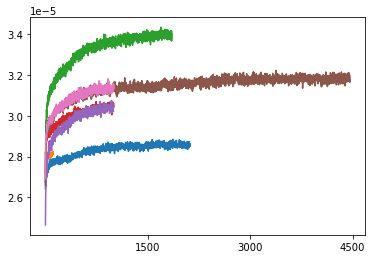

In [39]:
import matplotlib.pyplot as plt
for model in list(ds.data_vars):
    da = ds[model].dropna(dim='time').mean(dim=['lat', 'lon'])
    plt.plot(da.time.values, da.values)